In [1]:
import os
import pandas as pd
import numpy as np
import xgboost

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, fbeta_score
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

import scipy.sparse as sp

from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler

from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer, LancasterStemmer

import gensim

import re

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_data = pd.read_csv("input/train_v2.csv")
test_data = pd.read_csv("input/test_v2.csv")

In [3]:
train_data.head(1)

,article_id,title,url,publisher,hostname,timestamp,category
0,1,Forex - Pound drops to one-month lows against ...,http://www.nasdaq.com/article/forex-pound-drop...,NASDAQ,www.nasdaq.com,1.390000e+12,4


In [4]:
def read_warn_or_error_list(filename):
    with open(filename, errors='ignore') as f:
        lines = f.read().splitlines()
    _list = []
    for line in lines:
        _list.append(line.split(',')[0])
    return _list

In [5]:
success_train = 'raw_train_new/success.txt'
success_test = 'raw_test_new/success.txt'

In [6]:
success_train_list = read_warn_or_error_list(success_train)
success_test_list = read_warn_or_error_list(success_test)

In [7]:
# train_fulltext_list = []
# for i in train_data['article_id']:
#     if str(i) in success_train_list:
#         filename='raw_train_new/'+str(i)+'.txt'
#         with open(filename, 'r',errors='ignore') as data_file:
#             train_fulltext_list.append(train_data[train_data.article_id == i].title.iloc[0] * TITLE_REPLICATES+ ' ' + data_file.read().replace('\n', ''))
#     else:
#         train_fulltext_list.append(train_data[train_data.article_id == i].title.iloc[0] * TITLE_REPLICATES)

In [8]:
# test_fulltext_list = []
# for i in test_data['article_id']:
#     if str(i) in success_test_list:
#         filename='raw_test_new/'+str(i)+'.txt'
#         with open(filename, 'r',errors='ignore') as data_file:
#             test_fulltext_list.append(test_data[test_data.article_id == i].title.iloc[0] * TITLE_REPLICATES+ ' ' + data_file.read().replace('\n', ''))
#     else:
#         test_fulltext_list.append(test_data[test_data.article_id == i].title.iloc[0] * TITLE_REPLICATES)

In [9]:
#v2: remove numbers and punctuations
whitelist = set('abcdefghijklmnopqrstuvwxyz ABCDEFGHIJKLMNOPQRSTUVWXYZ')
train_data['text']=""
#train_data['title_clean']=""
for i in range(len(train_data['title'])):
    filename='raw_train_new/'+str(i+1)+'.txt'
    title=train_data['title'][i]
    title = re.sub(r"[,:.;@#\?\-\%\/!&$]+\ *", " ", title)
    title = ''.join(filter(whitelist.__contains__, title)).lower()
    title = ' '.join(title.split())
    # train_data['title_clean'][i]=title
    #add space to title
    train_data['title'][i]=title
    title=title+" "
    if os.path.exists(filename):
        with open(filename, 'r',errors='ignore') as data_file:
            data=data_file.read().replace('\n', '')
            data = re.sub(r"[,:.;@#\?\-\%\/!&$]+\ *", " ", data)
            data = ''.join(filter(whitelist.__contains__, data)).lower()
            data=' '.join(data.split())
        train_data['text'][i]=data  # title*TITLE_REPLICATES+data
    else:
        train_data['text'][i]=""  # title*TITLE_REPLICATES

/Users/ruizhi/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/Users/ruizhi/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizhi/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [10]:
#v2 remove numbers and punctuations
whitelist = set('abcdefghijklmnopqrstuvwxyz ABCDEFGHIJKLMNOPQRSTUVWXYZ')
test_data['text']=""
#test_data['title_clean']=""
for i in range(len(test_data['title'])):
    filename='raw_test_new/'+str(i+1)+'.txt'
    title=test_data['title'][i]
    title = re.sub(r"[,:.;@#\?\-\%\/!&$]+\ *", " ", title)
    title = ''.join(filter(whitelist.__contains__, title)).lower()
    title = ' '.join(title.split())
    #test_data['title_clean'][i]=title
    test_data['title'][i]=title
    title=title+" "
    if os.path.exists(filename):
        with open(filename, 'r',errors='ignore') as data_file:
            data=data_file.read().replace('\n', '')
            data = re.sub(r"[,:.;@#\?\-\%\/!&$]+\ *", " ", data)
            data = ''.join(filter(whitelist.__contains__, data)).lower()
            data=' '.join(data.split())
        test_data['text'][i]=data  # title*TITLE_REPLICATES +data
    else:
        test_data['text'][i]=""  # title*TITLE_REPLICATES

/Users/ruizhi/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Users/ruizhi/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizhi/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [11]:
train_data = train_data.assign(original_text=train_data.text)
test_data = test_data.assign(original_text=test_data.text)

# Read in and Preprocess Data

In [12]:
def stem(sent, stemmer_type='snowball'):
    '''
    stemmer_type can be porter, lancaster, or snowball
    '''
    if stemmer_type == 'porter':
        stemmer = PorterStemmer()
    elif stemmer_type == 'lancaster':
        stemmer = LancasterStemmer()
    else:
        stemmer = SnowballStemmer('english')
    
    words = gensim.utils.simple_preprocess(sent)
    return ' '.join([stemmer.stem(word) for word in words])

In [13]:
# #trainf='train_full_clean.txt'
# trainf='train_full.txt'
# #X = pd.read_csv(trainf,header=None,sep=",",names=['data'])
# with open(trainf) as f:
#     X = f.read().splitlines()

# df = pd.DataFrame({"data": train_fulltext_list})
# df = df.assign(article_id=train_data.article_id, category=train_data.category)
# df.head(1)

In [14]:
# #trainf='train_full_clean.txt'
# trainf='test_full.txt'
# #X = pd.read_csv(trainf,header=None,sep=",",names=['data'])
# with open(trainf) as f:
#     X = f.read().splitlines()

# df_test = pd.DataFrame({"data": test_fulltext_list})
# df_test = df_test.assign(article_id=test_data.article_id)
# df_test.head(1)

In [15]:
# df_noerror = df[df.article_id.isin(success_train_list)]
df_noerror = train_data

In [16]:
# df_test = df_test[df_test.article_id.isin(success_train_list)]
df_test = test_data

In [17]:
# perform stemming
df_noerror.loc[:, "original_text"] = df_noerror["original_text"].apply(stem)

In [18]:
df_noerror.loc[:, "title"] = df_noerror["title"].apply(stem)

In [19]:
df_test.loc[:, "original_text"] = df_test["original_text"].apply(stem)

In [20]:
df_test.loc[:, "title"] = df_test["title"].apply(stem)

In [21]:
TITLE_REPLICATES = 10

In [22]:
df_noerror.loc[:, "text"] = (df_noerror["title"] + " ")*TITLE_REPLICATES + df_noerror["original_text"]

In [23]:
df_test.loc[:, "text"] = (df_test["title"] + " ")*TITLE_REPLICATES + df_test["original_text"]

In [24]:
df_noerror.shape

(6027, 9)

In [25]:
df_test.shape

(3826, 8)

In [26]:
df_noerror.head(1)

,article_id,title,url,publisher,hostname,timestamp,category,text,original_text
0,1,forex pound drop to one month low against euro,http://www.nasdaq.com/article/forex-pound-drop...,NASDAQ,www.nasdaq.com,1.390000e+12,4,forex pound drop to one month low against euro...,invest com the pound fell to one month low aga...


In [27]:
df_test.head(1)

,article_id,title,url,publisher,hostname,timestamp,text,original_text
0,1,white hous play down speedi role for us natur ...,http://www.thestar.com.my/News/World/2014/03/0...,The Star Online,www.thestar.com.my,1.390000e+12,white hous play down speedi role for us natur ...,on board air forc one reuter the white hous on...


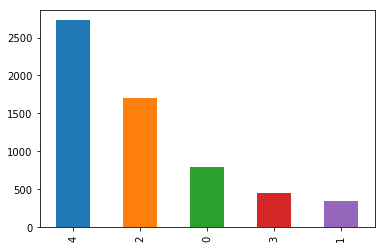

In [28]:
df_noerror.category.value_counts().plot('bar')

# Train Model

In [29]:
def train_model(classifier, feature_vector_train, label_train, feature_vector_valid, label_valid):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label_train)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    return {'accuracy': accuracy_score(label_valid, predictions), 
            # 'f2_seperate': fbeta_score(Y_test, Y_predict, average=None, beta=2),
            'f2_macro': fbeta_score(label_valid, predictions, average='macro', beta=2),
            'f2_micro': fbeta_score(label_valid, predictions, average='micro', beta=2),
            'f2_weighted': fbeta_score(label_valid, predictions, average='weighted', beta=2)}

In [30]:
def cross_validation_data(train_data):
    X = train_data["text"].values
    y = train_data["category"].values
    sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
    
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = y[train_index], y[test_index]
        yield X_train, Y_train, X_test, Y_test

# TF-IDF

In [72]:
# # use both title and content to fit tfidf
# tfidf_vect_ngram = TfidfVectorizer(analyzer='word',
#                                    # token_pattern=r'\w{1,}', 
#                                    ngram_range=(1,3), 
#                                    max_df=1.0,
#                                    min_df=1,
#                                    max_features=3500)

# tfidf_vect_ngram.fit(df_noerror["data"].tolist() + df_test["data"].tolist())

In [31]:
# use title only to fit tfidf
tfidf_vect_ngram = TfidfVectorizer(analyzer='word',
                                   # token_pattern=r'\w{1,}', 
                                   ngram_range=(1,3), 
                                   max_df=1.0,
                                   min_df=1,
                                   max_features=3500)

tfidf_vect_ngram.fit(train_data["title"].tolist() + test_data["title"].tolist())

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=3500, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [32]:
epochs = 1

In [38]:
from sklearn.semi_supervised import LabelPropagation, LabelSpreading

In [ ]:
alpha=0.8
0.6466

0.5
0.6432

0.9
0.6492

0.95
0.6497

In [77]:
# Use only high confident data as extra training data
metrics_list = []
for X_train, Y_train, X_test, Y_test in cross_validation_data(df_noerror):
#     clf = LogisticRegression(penalty='l2', C=2, solver='liblinear', multi_class='ovr')
#     clf = RandomForestClassifier(n_estimators=180, criterion='entropy')
#     clf = xgboost.XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=140)
    lp_model = LabelSpreading(kernel='rbf',
                              gamma=10, 
#                               n_neighbors=25,
                              alpha=0.95,
                              max_iter=50,
                              n_jobs=6)
    
    xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(X_train)
    xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(X_test)
    xsemi_tfidf_ngram = tfidf_vect_ngram.transform(np.concatenate([X_test, df_test["text"]]))

    # First training using only training set
    ysemi_unlabeld = -np.ones((X_test.shape[0]+df_test.shape[0],))
    lp_model.fit(sp.vstack((xtrain_tfidf_ngram, xsemi_tfidf_ngram)).toarray(),
                 np.concatenate((Y_train, ysemi_unlabeld)))
    predicted_labels = lp_model.transduction_[xtrain_tfidf_ngram.shape[0]:xtrain_tfidf_ngram.shape[0]+X_test.shape[0]]
    metrics = {'accuracy': accuracy_score(Y_test, predicted_labels)}

    # semi supervised stage
#     for epoch in range(epochs):
#         # create labels
#         prob_semi = clf.predict_proba(xsemi_tfidf_ngram)
#         THRESHOLD = 0.6
#         mask = np.amax(prob_semi, axis=1) > THRESHOLD

#         ysemi = clf.predict(xsemi_tfidf_ngram)

#         print(ysemi[mask].shape)

#         if epoch == epochs-1:
#             # Use SVC for last epoch
#             metrics = train_model(SVC(kernel='linear'),
#                                   sp.vstack((xtrain_tfidf_ngram, xsemi_tfidf_ngram[mask])),
#                                   np.concatenate((Y_train, ysemi[mask])), 
#                                   xvalid_tfidf_ngram, Y_test)
# #             metrics = train_model(xgboost.XGBClassifier(max_depth=5, n_estimators=140),
# #                               sp.vstack((xtrain_tfidf_ngram, xsemi_tfidf_ngram[mask])),
# #                               np.concatenate((Y_train, ysemi[mask])), 
# #                               xvalid_tfidf_ngram, Y_test)
#         else:
#             metrics = train_model(clf,
#                                   sp.vstack((xtrain_tfidf_ngram, xsemi_tfidf_ngram[mask])),
#                                   np.concatenate((Y_train, ysemi[mask])), 
#                                   xvalid_tfidf_ngram, Y_test)
    metrics_list.append(metrics)
    print(metrics)

print("mean accuracy:", sum([item['accuracy'] for item in metrics_list])/len(metrics_list))
# print("mean f2_macro:", sum([item['f2_macro'] for item in metrics_list])/len(metrics_list))    
# print("mean f2_micro:", sum([item['f2_micro'] for item in metrics_list])/len(metrics_list))    
# print("mean f2_weighted:", sum([item['f2_weighted'] for item in metrics_list])/len(metrics_list))  
print()

{'accuracy': 0.6500829187396352}


/Users/ruizhi/anaconda/lib/python3.6/site-packages/sklearn/semi_supervised/label_propagation.py:292: ConvergenceWarning: max_iter=50 was reached without convergence.
  category=ConvergenceWarning


{'accuracy': 0.6376451077943616}


/Users/ruizhi/anaconda/lib/python3.6/site-packages/sklearn/semi_supervised/label_propagation.py:292: ConvergenceWarning: max_iter=50 was reached without convergence.
  category=ConvergenceWarning


{'accuracy': 0.6517412935323383}


/Users/ruizhi/anaconda/lib/python3.6/site-packages/sklearn/semi_supervised/label_propagation.py:292: ConvergenceWarning: max_iter=50 was reached without convergence.
  category=ConvergenceWarning


{'accuracy': 0.6434494195688225}


/Users/ruizhi/anaconda/lib/python3.6/site-packages/sklearn/semi_supervised/label_propagation.py:292: ConvergenceWarning: max_iter=50 was reached without convergence.
  category=ConvergenceWarning


{'accuracy': 0.6616915422885572}


/Users/ruizhi/anaconda/lib/python3.6/site-packages/sklearn/semi_supervised/label_propagation.py:292: ConvergenceWarning: max_iter=50 was reached without convergence.
  category=ConvergenceWarning


{'accuracy': 0.6600331674958541}


/Users/ruizhi/anaconda/lib/python3.6/site-packages/sklearn/semi_supervised/label_propagation.py:292: ConvergenceWarning: max_iter=50 was reached without convergence.
  category=ConvergenceWarning


{'accuracy': 0.6376451077943616}


/Users/ruizhi/anaconda/lib/python3.6/site-packages/sklearn/semi_supervised/label_propagation.py:292: ConvergenceWarning: max_iter=50 was reached without convergence.
  category=ConvergenceWarning


{'accuracy': 0.6592039800995025}


/Users/ruizhi/anaconda/lib/python3.6/site-packages/sklearn/semi_supervised/label_propagation.py:292: ConvergenceWarning: max_iter=50 was reached without convergence.
  category=ConvergenceWarning


{'accuracy': 0.6774461028192371}


/Users/ruizhi/anaconda/lib/python3.6/site-packages/sklearn/semi_supervised/label_propagation.py:292: ConvergenceWarning: max_iter=50 was reached without convergence.
  category=ConvergenceWarning


{'accuracy': 0.6185737976782753}
mean accuracy: 0.6497512437810946



/Users/ruizhi/anaconda/lib/python3.6/site-packages/sklearn/semi_supervised/label_propagation.py:292: ConvergenceWarning: max_iter=50 was reached without convergence.
  category=ConvergenceWarning


In [53]:
from scipy import stats

In [103]:
# Use only high confident data as extra training data
metrics_list = []
for X_train, Y_train, X_test, Y_test in cross_validation_data(df_noerror):
#     clf = LogisticRegression(penalty='l2', C=2, solver='liblinear', multi_class='ovr')
#     clf = RandomForestClassifier(n_estimators=180, criterion='entropy')
#     clf = xgboost.XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=140)
    lp_model = LabelSpreading(kernel='rbf',
                              gamma=10, 
#                               n_neighbors=25,
                              alpha=0.95,
                              max_iter=50,
                              n_jobs=6)
    
    xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(X_train)
    xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(X_test)
    xsemi_tfidf_ngram = tfidf_vect_ngram.transform(np.concatenate([X_test, df_test["text"]]))

    # First training using only training set
    ysemi_unlabeld = -np.ones((X_test.shape[0]+df_test.shape[0],))
    lp_model.fit(sp.vstack((xtrain_tfidf_ngram, xsemi_tfidf_ngram)).toarray(),
                 np.concatenate((Y_train, ysemi_unlabeld)))
    
    ysemi = lp_model.transduction_[xtrain_tfidf_ngram.shape[0]:]
    
    # semi supervised stage
    THRESHOLD = 0.8
#     pred_entropies_semi = stats.distributions.entropy(lp_model.label_distributions_.T)[X_train.shape[0]:]
#     mask = pred_entropies_semi < THRESHOLD

    mask = np.amax(lp_model.label_distributions_[X_train.shape[0]:], axis=1) > THRESHOLD
    
    print(ysemi[mask].shape)

    # Use SVC for last epoch
    metrics = train_model(SVC(kernel='linear'),
                          sp.vstack((xtrain_tfidf_ngram, xsemi_tfidf_ngram[mask])),
                          np.concatenate((Y_train, ysemi[mask])), 
                          xvalid_tfidf_ngram, Y_test)
#             metrics = train_model(xgboost.XGBClassifier(max_depth=5, n_estimators=140),
#                               sp.vstack((xtrain_tfidf_ngram, xsemi_tfidf_ngram[mask])),
#                               np.concatenate((Y_train, ysemi[mask])), 
#                               xvalid_tfidf_ngram, Y_test)

    metrics_list.append(metrics)
    print(metrics)

print("mean accuracy:", sum([item['accuracy'] for item in metrics_list])/len(metrics_list))
# print("mean f2_macro:", sum([item['f2_macro'] for item in metrics_list])/len(metrics_list))    
# print("mean f2_micro:", sum([item['f2_micro'] for item in metrics_list])/len(metrics_list))    
# print("mean f2_weighted:", sum([item['f2_weighted'] for item in metrics_list])/len(metrics_list))  
print()

(1369,)


/Users/ruizhi/anaconda/lib/python3.6/site-packages/sklearn/semi_supervised/label_propagation.py:292: ConvergenceWarning: max_iter=50 was reached without convergence.
  category=ConvergenceWarning


{'accuracy': 0.6666666666666666, 'f2_macro': 0.5663517272397725, 'f2_micro': 0.6666666666666666, 'f2_weighted': 0.658071300219084}
(1327,)


/Users/ruizhi/anaconda/lib/python3.6/site-packages/sklearn/semi_supervised/label_propagation.py:292: ConvergenceWarning: max_iter=50 was reached without convergence.
  category=ConvergenceWarning


{'accuracy': 0.6625207296849088, 'f2_macro': 0.5366012560074029, 'f2_micro': 0.6625207296849088, 'f2_weighted': 0.6508284168551369}
(1320,)


/Users/ruizhi/anaconda/lib/python3.6/site-packages/sklearn/semi_supervised/label_propagation.py:292: ConvergenceWarning: max_iter=50 was reached without convergence.
  category=ConvergenceWarning


{'accuracy': 0.6724709784411277, 'f2_macro': 0.5608287694439502, 'f2_micro': 0.6724709784411277, 'f2_weighted': 0.6611779036131425}
(1368,)


/Users/ruizhi/anaconda/lib/python3.6/site-packages/sklearn/semi_supervised/label_propagation.py:292: ConvergenceWarning: max_iter=50 was reached without convergence.
  category=ConvergenceWarning


{'accuracy': 0.6674958540630183, 'f2_macro': 0.5815700878483403, 'f2_micro': 0.6674958540630183, 'f2_weighted': 0.659103113925878}
(1317,)


/Users/ruizhi/anaconda/lib/python3.6/site-packages/sklearn/semi_supervised/label_propagation.py:292: ConvergenceWarning: max_iter=50 was reached without convergence.
  category=ConvergenceWarning


{'accuracy': 0.6741293532338308, 'f2_macro': 0.5976637318512521, 'f2_micro': 0.6741293532338308, 'f2_weighted': 0.6648936071711207}
(1322,)


/Users/ruizhi/anaconda/lib/python3.6/site-packages/sklearn/semi_supervised/label_propagation.py:292: ConvergenceWarning: max_iter=50 was reached without convergence.
  category=ConvergenceWarning


{'accuracy': 0.6741293532338308, 'f2_macro': 0.5690509060279768, 'f2_micro': 0.6741293532338308, 'f2_weighted': 0.6662102889579999}
(1346,)


/Users/ruizhi/anaconda/lib/python3.6/site-packages/sklearn/semi_supervised/label_propagation.py:292: ConvergenceWarning: max_iter=50 was reached without convergence.
  category=ConvergenceWarning


{'accuracy': 0.6699834162520729, 'f2_macro': 0.5648122194682588, 'f2_micro': 0.6699834162520729, 'f2_weighted': 0.6609181592045426}
(1342,)


/Users/ruizhi/anaconda/lib/python3.6/site-packages/sklearn/semi_supervised/label_propagation.py:292: ConvergenceWarning: max_iter=50 was reached without convergence.
  category=ConvergenceWarning


{'accuracy': 0.693200663349917, 'f2_macro': 0.5793261221669161, 'f2_micro': 0.693200663349917, 'f2_weighted': 0.6830639188519616}
(1295,)


/Users/ruizhi/anaconda/lib/python3.6/site-packages/sklearn/semi_supervised/label_propagation.py:292: ConvergenceWarning: max_iter=50 was reached without convergence.
  category=ConvergenceWarning


{'accuracy': 0.693200663349917, 'f2_macro': 0.5870118259100445, 'f2_micro': 0.693200663349917, 'f2_weighted': 0.6843917429256634}
(1332,)


/Users/ruizhi/anaconda/lib/python3.6/site-packages/sklearn/semi_supervised/label_propagation.py:292: ConvergenceWarning: max_iter=50 was reached without convergence.
  category=ConvergenceWarning


{'accuracy': 0.6475953565505804, 'f2_macro': 0.5540362781706555, 'f2_micro': 0.6475953565505804, 'f2_weighted': 0.6400347780645526}
mean accuracy: 0.6721393034825871



In [ ]:
0.6
0.6708

0.55
0.6693

0.5
0.6673

0.7
0.6713

0.8
0.6721

In [104]:
# CREATE SUBMISSION

# Use only high confident data as extra training data
metrics_list = []

lp_model = LabelSpreading(kernel='rbf',
                          gamma=10, 
#                         n_neighbors=25,
                          alpha=0.95,
                          max_iter=50,
                          n_jobs=6)

train_tfidf_ngram =  tfidf_vect_ngram.transform(df_noerror["text"])
xsemi_tfidf_ngram = tfidf_vect_ngram.transform(df_test["text"])

ysemi_unlabeld = -np.ones((df_test.shape[0],))
lp_model.fit(sp.vstack((train_tfidf_ngram, xsemi_tfidf_ngram)).toarray(),
             np.concatenate((df_noerror["category"], ysemi_unlabeld)))

# semi supervised stage
# create labels
ysemi = lp_model.transduction_[df_noerror.shape[0]:]
THRESHOLD = 0.8
mask = np.amax(lp_model.label_distributions_[df_noerror.shape[0]:], axis=1) > THRESHOLD

print(ysemi[mask].shape)

# Use SVC for last epoch
final_clf = SVC(kernel='linear')
metrics = train_model(final_clf,
                  sp.vstack((train_tfidf_ngram, xsemi_tfidf_ngram[mask])),
                  np.concatenate((df_noerror["category"], ysemi[mask])), 
                  train_tfidf_ngram, df_noerror["category"])

metrics_list.append(metrics)

print("On training set: ")
print("mean accuracy:", sum([item['accuracy'] for item in metrics_list])/len(metrics_list))
print("mean f2_macro:", sum([item['f2_macro'] for item in metrics_list])/len(metrics_list))    
print("mean f2_micro:", sum([item['f2_micro'] for item in metrics_list])/len(metrics_list))    
print("mean f2_weighted:", sum([item['f2_weighted'] for item in metrics_list])/len(metrics_list))  
print()

(961,)


/Users/ruizhi/anaconda/lib/python3.6/site-packages/sklearn/semi_supervised/label_propagation.py:292: ConvergenceWarning: max_iter=50 was reached without convergence.
  category=ConvergenceWarning


On training set: 
mean accuracy: 0.7363530778164924
mean f2_macro: 0.6264230999234784
mean f2_micro: 0.7363530778164924
mean f2_weighted: 0.7280533353192284



In [107]:
final_clf.predict(xsemi_tfidf_ngram)[:10]

array([4., 4., 4., 4., 4., 4., 4., 4., 2., 2.])

In [108]:
df_test.shape

(3826, 9)

In [110]:
df_test["category"] = [int(i) for i in final_clf.predict(xsemi_tfidf_ngram)]

out = pd.DataFrame(df_test,columns=['article_id','category'])
out.to_csv('prediction_fulltext_1436.csv',index=False)

In [31]:
# Use only high confident data as extra training data
metrics_list = []
for X_train, Y_train, X_test, Y_test in cross_validation_data(df_noerror):
#     clf = LogisticRegression(penalty='l2', C=2, solver='liblinear', multi_class='ovr')
    clf = RandomForestClassifier(n_estimators=180, criterion='entropy')
#     clf = xgboost.XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=140)
    
    xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(X_train)
    xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(X_test)
    xsemi_tfidf_ngram = tfidf_vect_ngram.transform(np.concatenate([X_test, df_test["text"]]))

    # First training using only training set
    _ = train_model(clf, xtrain_tfidf_ngram, Y_train, xvalid_tfidf_ngram, Y_test)

    # semi supervised stage
    for epoch in range(epochs):
        # create labels
        prob_semi = clf.predict_proba(xsemi_tfidf_ngram)
        THRESHOLD = 0.6
        mask = np.amax(prob_semi, axis=1) > THRESHOLD

        ysemi = clf.predict(xsemi_tfidf_ngram)

        print(ysemi[mask].shape)

        if epoch == epochs-1:
            # Use SVC for last epoch
            metrics = train_model(SVC(kernel='linear'),
                                  sp.vstack((xtrain_tfidf_ngram, xsemi_tfidf_ngram[mask])),
                                  np.concatenate((Y_train, ysemi[mask])), 
                                  xvalid_tfidf_ngram, Y_test)
#             metrics = train_model(xgboost.XGBClassifier(max_depth=5, n_estimators=140),
#                               sp.vstack((xtrain_tfidf_ngram, xsemi_tfidf_ngram[mask])),
#                               np.concatenate((Y_train, ysemi[mask])), 
#                               xvalid_tfidf_ngram, Y_test)
        else:
            metrics = train_model(clf,
                                  sp.vstack((xtrain_tfidf_ngram, xsemi_tfidf_ngram[mask])),
                                  np.concatenate((Y_train, ysemi[mask])), 
                                  xvalid_tfidf_ngram, Y_test)
    metrics_list.append(metrics)

print("mean accuracy:", sum([item['accuracy'] for item in metrics_list])/len(metrics_list))
print("mean f2_macro:", sum([item['f2_macro'] for item in metrics_list])/len(metrics_list))    
print("mean f2_micro:", sum([item['f2_micro'] for item in metrics_list])/len(metrics_list))    
print("mean f2_weighted:", sum([item['f2_weighted'] for item in metrics_list])/len(metrics_list))  
print()

(2960,)
(3079,)
(2963,)
(3019,)
(2971,)
(3030,)
(2990,)
(2994,)
(2955,)
(2977,)
mean accuracy: 0.6745439469320066
mean f2_macro: 0.5727358042809104
mean f2_micro: 0.6745439469320065
mean f2_weighted: 0.6646584349924545



In [ ]:
title_replicates=6, without using stem, threshold = 0.6
0.6742, 0.5699

title_replicates=6, using stem, threshold = 0.6
0.6752, 0.5723

using high conf for training set, title_replicates=6, using stem, threshold = 0.6
0.6766

In [ ]:
title_replicates=10, using stem, threshold = 0.6
0.6748

high_conf for train, title_replicates=10, using stem, threshold = 0.6
0.6690

In [ ]:
title_replicates=20, using stem, threshold = 0.6
0.6727

using high conf for training set, title_replicates=20, using stem, threshold = 0.6
0.6717

In [ ]:
title_replicates=10, using stem
threshold

0.8
0.6723

0.6
0.6759

0.5
0.6722

0.0
0.6664

In [32]:
# Use high confident data as extra training data
# Use high confident training data as training data
metrics_list = []
for X_train, Y_train, X_test, Y_test in cross_validation_data(df_noerror):
#     clf = LogisticRegression(penalty='l2', C=2, solver='liblinear', multi_class='ovr')
#     clf = RandomForestClassifier(n_estimators=180, criterion='entropy')
    clf = xgboost.XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=140)
    
    xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(X_train)
    xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(X_test)
    xsemi_tfidf_ngram = tfidf_vect_ngram.transform(np.concatenate([X_test, df_test["text"]]))

    # First training using only training set
    _ = train_model(clf, xtrain_tfidf_ngram, Y_train, xvalid_tfidf_ngram, Y_test)

    # semi supervised stage
    for epoch in range(epochs):
        # create labels
        prob_train = clf.predict_proba(xtrain_tfidf_ngram)
        prob_semi = clf.predict_proba(xsemi_tfidf_ngram)
        THRESHOLD = 0.6
        mask_train = np.amax(prob_train, axis=1) > THRESHOLD
        mask = np.amax(prob_semi, axis=1) > THRESHOLD

        ysemi = clf.predict(xsemi_tfidf_ngram)

        print(ysemi[mask].shape)

        if epoch == epochs-1:
            # Use SVC for last epoch
            metrics = train_model(SVC(kernel='linear'),
                                  sp.vstack((xtrain_tfidf_ngram[mask_train], xsemi_tfidf_ngram[mask])),
                                  np.concatenate((Y_train[mask_train], ysemi[mask])), 
                                  xvalid_tfidf_ngram, Y_test)
#             metrics = train_model(xgboost.XGBClassifier(max_depth=5, n_estimators=140),
#                               sp.vstack((xtrain_tfidf_ngram, xsemi_tfidf_ngram[mask])),
#                               np.concatenate((Y_train, ysemi[mask])), 
#                               xvalid_tfidf_ngram, Y_test)
        else:
            metrics = train_model(clf,
                                  sp.vstack((xtrain_tfidf_ngram[mask_train], xsemi_tfidf_ngram[mask])),
                                  np.concatenate((Y_train[mask_train], ysemi[mask])), 
                                  xvalid_tfidf_ngram, Y_test)
    metrics_list.append(metrics)

print("mean accuracy:", sum([item['accuracy'] for item in metrics_list])/len(metrics_list))
print("mean f2_macro:", sum([item['f2_macro'] for item in metrics_list])/len(metrics_list))    
print("mean f2_micro:", sum([item['f2_micro'] for item in metrics_list])/len(metrics_list))    
print("mean f2_weighted:", sum([item['f2_weighted'] for item in metrics_list])/len(metrics_list))  
print()

(3487,)
(3526,)
(3516,)
(3480,)
(3412,)
(3465,)
(3445,)
(3442,)
(3426,)
(3529,)
mean accuracy: 0.6713101160862354
mean f2_macro: 0.565372718338484
mean f2_micro: 0.6713101160862354
mean f2_weighted: 0.6593736716144306



In [ ]:
# warn, epoch=1

# RF + SVC, 0.6
# 0.6749  # however does NOT improve final submission

# RF + SVC, 0.7
# 0.6753

# RF + SVC, 0.8
# 0.6744

In [49]:
# a single classifier
metrics_list = []
for X_train, Y_train, X_test, Y_test in cross_validation_data(df_noerror):
#     clf = LogisticRegression(penalty='l2', C=2, solver='liblinear', multi_class='ovr')
#     clf = RandomForestClassifier(n_estimators=180, criterion='entropy')
#     clf = xgboost.XGBClassifier(max_depth=5, n_estimators=140)
    clf = SVC(kernel='linear')
    
    xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(X_train)
    xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(X_test)
    metrics = train_model(clf, xtrain_tfidf_ngram, Y_train, xvalid_tfidf_ngram, Y_test)
    
    print(metrics)
    metrics_list.append(metrics)

print("mean accuracy:", sum([item['accuracy'] for item in metrics_list])/len(metrics_list))
print("mean f2_macro:", sum([item['f2_macro'] for item in metrics_list])/len(metrics_list))    
print("mean f2_micro:", sum([item['f2_micro'] for item in metrics_list])/len(metrics_list))    
print("mean f2_weighted:", sum([item['f2_weighted'] for item in metrics_list])/len(metrics_list))  
print()

{'accuracy': 0.664179104477612, 'f2_macro': 0.5598825270772545, 'f2_micro': 0.664179104477612, 'f2_weighted': 0.6544175354132418}
{'accuracy': 0.6583747927031509, 'f2_macro': 0.5340564591583843, 'f2_micro': 0.6583747927031509, 'f2_weighted': 0.6466752674710315}
{'accuracy': 0.6733001658374793, 'f2_macro': 0.5559213384390573, 'f2_micro': 0.6733001658374793, 'f2_weighted': 0.6616446004646143}
{'accuracy': 0.6633499170812603, 'f2_macro': 0.5676067079626416, 'f2_micro': 0.6633499170812603, 'f2_weighted': 0.6536294834846148}
{'accuracy': 0.6708126036484245, 'f2_macro': 0.592227189547627, 'f2_micro': 0.6708126036484245, 'f2_weighted': 0.6609985405874532}
{'accuracy': 0.6666666666666666, 'f2_macro': 0.5584270955120385, 'f2_micro': 0.6666666666666666, 'f2_weighted': 0.6580148476825817}
{'accuracy': 0.6708126036484245, 'f2_macro': 0.5573280800842287, 'f2_micro': 0.6708126036484245, 'f2_weighted': 0.6612956322890229}
{'accuracy': 0.6898839137645107, 'f2_macro': 0.5696537659866285, 'f2_micro': 0.

In [45]:
predictions_list = []

In [46]:
# CREATE SUBMISSION

# Use only high confident data as extra training data
metrics_list = []

# clf = LogisticRegression(penalty='l2', C=2, solver='liblinear', multi_class='ovr')
clf = RandomForestClassifier(n_estimators=180, criterion='entropy')

train_tfidf_ngram =  tfidf_vect_ngram.transform(df_noerror["text"])
xsemi_tfidf_ngram = tfidf_vect_ngram.transform(df_test["text"])

# First training using only training set
_ = train_model(clf, train_tfidf_ngram, df_noerror["category"], train_tfidf_ngram, df_noerror["category"])

# semi supervised stage
for epoch in range(epochs):
    # create labels
    prob_semi = clf.predict_proba(xsemi_tfidf_ngram)
    THRESHOLD = 0.6
    mask = np.amax(prob_semi, axis=1) > THRESHOLD

    ysemi = clf.predict(xsemi_tfidf_ngram)

    print(ysemi[mask].shape)

    if epoch == epochs-1:
        # Use SVC for last epoch
        final_clf = SVC(kernel='linear')
        metrics = train_model(final_clf,
                          sp.vstack((train_tfidf_ngram, xsemi_tfidf_ngram[mask])),
                          np.concatenate((df_noerror["category"], ysemi[mask])), 
                          train_tfidf_ngram, df_noerror["category"])
    else:
        metrics = train_model(clf,
                          sp.vstack((train_tfidf_ngram, xsemi_tfidf_ngram[mask])),
                          np.concatenate((df_noerror["category"], ysemi[mask])), 
                          train_tfidf_ngram, df_noerror["category"])
metrics_list.append(metrics)

print("On training set: ")
print("mean accuracy:", sum([item['accuracy'] for item in metrics_list])/len(metrics_list))
print("mean f2_macro:", sum([item['f2_macro'] for item in metrics_list])/len(metrics_list))    
print("mean f2_micro:", sum([item['f2_micro'] for item in metrics_list])/len(metrics_list))    
print("mean f2_weighted:", sum([item['f2_weighted'] for item in metrics_list])/len(metrics_list))  
print()

(2400,)
On training set: 
mean accuracy: 0.7353575576572092
mean f2_macro: 0.6255968857777343
mean f2_micro: 0.7353575576572092
mean f2_weighted: 0.7268130099549321



In [47]:
predictions_list.append(final_clf.predict(xsemi_tfidf_ngram))

In [48]:
# CREATE SUBMISSION

# Use only high confident data as extra training data
metrics_list = []

# clf = LogisticRegression(penalty='l2', C=2, solver='liblinear', multi_class='ovr')
clf = RandomForestClassifier(n_estimators=180, criterion='entropy')

train_tfidf_ngram =  tfidf_vect_ngram.transform(df_noerror["text"])
xsemi_tfidf_ngram = tfidf_vect_ngram.transform(df_test["text"])

# First training using only training set
_ = train_model(clf, train_tfidf_ngram, df_noerror["category"], train_tfidf_ngram, df_noerror["category"])

# semi supervised stage
for epoch in range(epochs):
    # create labels
    prob_semi = clf.predict_proba(xsemi_tfidf_ngram)
    THRESHOLD = 0.6
    mask = np.amax(prob_semi, axis=1) > THRESHOLD

    ysemi = clf.predict(xsemi_tfidf_ngram)

    print(ysemi[mask].shape)

    if epoch == epochs-1:
        # Use SVC for last epoch
        final_clf = SVC(kernel='linear')
        metrics = train_model(final_clf,
                          sp.vstack((train_tfidf_ngram, xsemi_tfidf_ngram[mask])),
                          np.concatenate((df_noerror["category"], ysemi[mask])), 
                          train_tfidf_ngram, df_noerror["category"])
    else:
        metrics = train_model(clf,
                          sp.vstack((train_tfidf_ngram, xsemi_tfidf_ngram[mask])),
                          np.concatenate((df_noerror["category"], ysemi[mask])), 
                          train_tfidf_ngram, df_noerror["category"])
metrics_list.append(metrics)

print("On training set: ")
print("mean accuracy:", sum([item['accuracy'] for item in metrics_list])/len(metrics_list))
print("mean f2_macro:", sum([item['f2_macro'] for item in metrics_list])/len(metrics_list))    
print("mean f2_micro:", sum([item['f2_micro'] for item in metrics_list])/len(metrics_list))    
print("mean f2_weighted:", sum([item['f2_weighted'] for item in metrics_list])/len(metrics_list))  
print()

(2376,)
On training set: 
mean accuracy: 0.73353243736519
mean f2_macro: 0.6236483792314528
mean f2_micro: 0.73353243736519
mean f2_weighted: 0.7249394600144747



In [49]:
predictions_list.append(final_clf.predict(xsemi_tfidf_ngram))

In [50]:
# CREATE SUBMISSION

# Use only high confident data as extra training data
metrics_list = []

# clf = LogisticRegression(penalty='l2', C=2, solver='liblinear', multi_class='ovr')
clf = RandomForestClassifier(n_estimators=180, criterion='entropy')

train_tfidf_ngram =  tfidf_vect_ngram.transform(df_noerror["text"])
xsemi_tfidf_ngram = tfidf_vect_ngram.transform(df_test["text"])

# First training using only training set
_ = train_model(clf, train_tfidf_ngram, df_noerror["category"], train_tfidf_ngram, df_noerror["category"])

# semi supervised stage
for epoch in range(epochs):
    # create labels
    prob_semi = clf.predict_proba(xsemi_tfidf_ngram)
    THRESHOLD = 0.6
    mask = np.amax(prob_semi, axis=1) > THRESHOLD

    ysemi = clf.predict(xsemi_tfidf_ngram)

    print(ysemi[mask].shape)

    if epoch == epochs-1:
        # Use SVC for last epoch
        final_clf = SVC(kernel='linear')
        metrics = train_model(final_clf,
                          sp.vstack((train_tfidf_ngram, xsemi_tfidf_ngram[mask])),
                          np.concatenate((df_noerror["category"], ysemi[mask])), 
                          train_tfidf_ngram, df_noerror["category"])
    else:
        metrics = train_model(clf,
                          sp.vstack((train_tfidf_ngram, xsemi_tfidf_ngram[mask])),
                          np.concatenate((df_noerror["category"], ysemi[mask])), 
                          train_tfidf_ngram, df_noerror["category"])
metrics_list.append(metrics)

print("On training set: ")
print("mean accuracy:", sum([item['accuracy'] for item in metrics_list])/len(metrics_list))
print("mean f2_macro:", sum([item['f2_macro'] for item in metrics_list])/len(metrics_list))    
print("mean f2_micro:", sum([item['f2_micro'] for item in metrics_list])/len(metrics_list))    
print("mean f2_weighted:", sum([item['f2_weighted'] for item in metrics_list])/len(metrics_list))  
print()

(2391,)
On training set: 
mean accuracy: 0.734362037497926
mean f2_macro: 0.6248781419612619
mean f2_micro: 0.734362037497926
mean f2_weighted: 0.7259651814405409



In [52]:
def fuse_results(predictions_list, xgb_offset=1):
    final_predictions = []
    percentage = 0
    for preds in zip(*predictions_list):
        sr_count = pd.Series(preds).value_counts()
        if sr_count.iloc[0] >= 2 and sr_count.index[0] != preds[1]:
            final_predictions.append(sr_count.index[0])  # the most commonly predicted class
            percentage +=1
        else:
            final_predictions.append(preds[1])  # use result of xgb
    
    print(percentage)
    return final_predictions

In [53]:
len(predictions_list)

3

In [54]:
final_predictions = fuse_results(predictions_list, xgb_offset=0)

14


In [55]:
df_test["category"] = final_predictions

out = pd.DataFrame(df_test,columns=['article_id','category'])
out.to_csv('prediction_fulltext.csv',index=False)

In [57]:
df_test["category"] = final_clf.predict(xsemi_tfidf_ngram)

out = pd.DataFrame(df_test,columns=['article_id','category'])
out.to_csv('prediction_fulltext.csv',index=False)

In [70]:
# Linear Classifier on Ngram Level TF IDF Vectors
accuracy = train_model(LogisticRegression(penalty='l2', C=1.25, solver='lbfgs'), xtrain_tfidf_ngram, Y_train, xvalid_tfidf_ngram, Y_test)
print("LR, N-Gram Vectors: ", accuracy)

LR, N-Gram Vectors:  0.6826462128475551


In [71]:
# Naive Bayes Classifier on Ngram Level TF IDF Vectors
accuracy = train_model(MultinomialNB(alpha=0.8), xtrain_tfidf_ngram, Y_train, xvalid_tfidf_ngram, Y_test)
print("NB, N-Gram Vectors: ", accuracy)

NB, N-Gram Vectors:  0.6586768935762224


In [30]:
# Extereme Gradient Boosting on Word Level TF IDF Vectors
accuracy = train_model(xgboost.XGBClassifier(max_depth=6, learning_rate=0.1, n_estimators=160), xtrain_tfidf_ngram.tocsc(), Y_train, xvalid_tfidf_ngram.tocsc(), Y_test)
print("Xgb, WordLevel TF-IDF: ", accuracy)

Xgb, WordLevel TF-IDF:  0.6711409395973155


/Users/ruizhi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [49]:
# Random Forest on Ngram Level TF IDF Vectors
accuracy = train_model(RandomForestClassifier(n_estimators=200, criterion='entropy'), xtrain_tfidf_ngram, Y_train, xvalid_tfidf_ngram, Y_test)
print("RF, N-Gram Vectors: ", accuracy)

RF, N-Gram Vectors:  0.653910149750416


In [52]:
# It seems that by filtering out those in the train_warn_list, the accuracy obtained is higher.

# Create Submission Using Different Mothods

In [155]:
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,3), max_features=3000)
tfidf_vect_ngram.fit(df_noerror["data"])

train_tfidf_ngram =  tfidf_vect_ngram.transform(df_noerror["data"])
test_tfidf_ngram =  tfidf_vect_ngram.transform(df_test["data"])

/Users/ruizhi/anaconda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [156]:
classifier = LogisticRegression(penalty='l2', C=1.25, solver='lbfgs')
accuracy = train_model(classifier, train_tfidf_ngram, df_noerror["category"], train_tfidf_ngram, df_noerror["category"])
print("LR on training set ", accuracy)

LR on training set  0.7286509307234695


In [ ]:
# Naive Bayes Classifier on Ngram Level TF IDF Vectors
classifier =  MultinomialNB()
accuracy = train_model(classifier, train_tfidf_ngram, df_noerror["category"], train_tfidf_ngram, df_noerror["category"])
print("NB on training set ", accuracy)

In [157]:
classifier = xgboost.XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=140)
accuracy = train_model(classifier, train_tfidf_ngram, df_noerror["category"], train_tfidf_ngram, df_noerror["category"])
print("XGB on training set ", accuracy)

XGB on training set  0.8842832469775475


/Users/ruizhi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [163]:
classifier = RandomForestClassifier(n_estimators=180, criterion='entropy')
accuracy = train_model(classifier, train_tfidf_ngram, df_noerror["category"], train_tfidf_ngram, df_noerror["category"])
print("RF on training set ", accuracy)

RF on training set  0.998272884283247


In [164]:
# test_data["category"] = classifier.predict(test_tfidf_ngram.tocsc())
df_test["category"] = classifier.predict(test_tfidf_ngram)

out = pd.DataFrame(df_test,columns=['article_id','category'])
out.to_csv('prediction_fulltext.csv',index=False)

# Update prediction by title

In [94]:
df_pred = pd.read_csv('prediction.csv')
df_pred_fulltext = pd.read_csv('prediction_fulltext.csv')

In [95]:
updated_id = []
updated_cat = []
num_diff = 0
for row in df_pred.itertuples():
    updated_id.append(row.article_id)
    cat_1 = row.category
    _ls = df_pred_fulltext[df_pred_fulltext.article_id==row.article_id].category.values
   
    if _ls.size > 0:  # if calculated in fulltext prediction
        cat_2 = _ls[0]
        # print(cat_1, cat_2)
        updated_cat.append(cat_2)
        if cat_1 != cat_2:
            num_diff += 1
    else:
        updated_cat.append(cat_1)

In [96]:
df_updated = pd.DataFrame({
    'article_id': updated_id,
    'category': updated_cat
})

In [97]:
df_updated.to_csv('prediction_updated.csv',index=False)